## Style Transfer Image Reconstruction
> ### 참고자료
[나동빈, Style Transfer 코드](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Style_Transfer_Tutorial.ipynb)

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

### 이미지 부르고 시각화하는 함수
- ```이미지 불러오기``` 파일에 있는 코드를 재사용했음
- ```image_loader``` 함수는 이미지를 불러와서 텐서로 변환해주는 함수
- ```imshow``` 함수는 텐서 형태의 이미지를 화면에 출력하는 함수

In [2]:
def image_loader(img_path, imsize): # 이미지 경로와 이미지 사이즈(튜플)을 입력받음
    # transform 정의
    # 사이즈 변경하고 텐서로 변경
    loader = transforms.Compose([transforms.Resize(imsize),
                                 transforms.ToTensor()]) # [0,255] -> [0,1]
    
    image = PIL.Image.open(img_path)
    image = loader(image).unsqueeze(0) # 배치 차원을 추가 (네트워크 입력에 필요)
    
    # GPU에 이미지를 올림
    return image.to(device, torch.float)

def imshow(tensor):
    # matplotlib은 CPU 기반이므로 cpu로 올린다
    image = tensor.cpu().clone()
    # 배치 차원을 제거해야 함
    image = image.squeeze(0)
    # PIL 객체로 변경해야 함
    image = transforms.ToPILImage()(image)
    
    # 이미지를 시각화(출력)
    plt.imshow(image)
    plt.show()

In [3]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 목표 이미지 불러오기

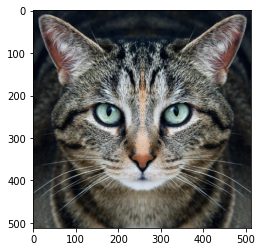

torch.Size([1, 3, 512, 512])


In [5]:
img_path = './cat.jpg'
# 이미지 사이즈를 (512, 512)로 맞춤
target_image = image_loader(img_path, (512, 512))
imshow(target_image)
print(target_image.shape)

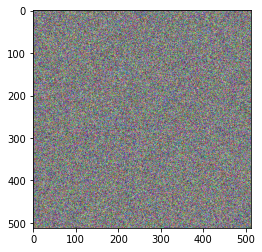

torch.Size([1, 3, 512, 512])


In [7]:
noise = torch.empty_like(target_image).uniform_(0, 1).to(device)
imshow(noise)
print(noise.shape)

### Image Reconstruction
- Noise 이미지를 목표 이미지로 변환한다.
- 손실함수로 MSE를 이용해서 이미지를 최적화한다.

Image Reconstruction Start


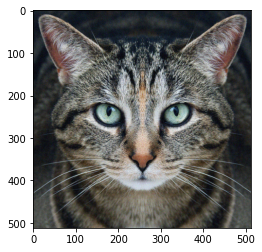

Step: 10
Loss: 0.0006028145435266197


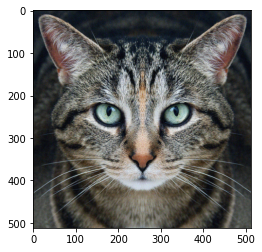

Step: 20
Loss: 0.00036010798066854477


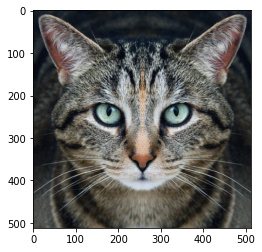

Step: 30
Loss: 0.00021512049715965986


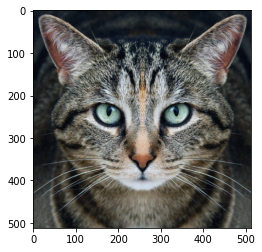

Step: 40
Loss: 0.00012850819621235132


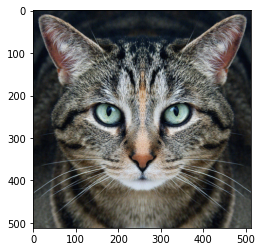

Step: 50
Loss: 7.67679448472336e-05


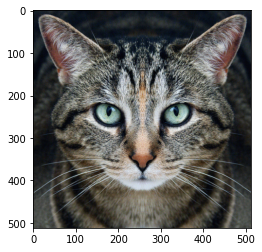

In [11]:
# loss function
loss = nn.MSELoss()
iters = 50
lr = 1e4

print("Image Reconstruction Start")
imshow(noise)

for i in range(iters):
    # noise에 torch.Tensor 연산을 추적하기 위해 requires_grad를 True로 설정
    noise.requires_grad = True

    # loss function에 대하여 미분하여 기울기를 계산
    output = loss(noise, target_image)
    output.backward()

    # 위에서 계산된 기울기를 이용해서 loss function이 감소하는 방향으로 업데이트
    gradient = lr * noise.grad # 업데이트를 위한 그래디언트

    # 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자른다.
    # 조금씩 noise 이미지가 target에 가까워짐
    # 마지막에 연산 추적을 중단하기 위해 detach() 사용 -> 어차피 iter 반복할때마다 requires_grad를 주고 있음
    noise = torch.clamp(noise - gradient, min=0, max=1).detach_()

    # 일정 iter마다 시각화
    if (i+1) % 10 == 0:
        print(f'Step: {i+1}')
        print(f'Loss: {output}')
        imshow(noise)